# Una mirada al mundo de la especulación

### Imports

In [2]:
import math

import requests
import sklearn
from datetime import datetime, timedelta
from requests_html import AsyncHTMLSession
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import secret
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import nest_asyncio


In [3]:
nest_asyncio.apply()

### Config:

### 1) Twitter scrapping

In [34]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(executable_path=os.path.abspath("chromedriver"), chrome_options=chrome_options)

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  
c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: use options instead of chrome_options
  


In [39]:
driver.get("https://twitter.com/search?q=bitcoin&src=typed_query")

c:\users\vasco\dataspellprojects\proyecto-icdd-g9\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  


[]

El siguiente codigo se va a tomar bastante tiempo, ya que literalmente tiene que navegar por twitter en un browser oculto

In [450]:
from datetime import datetime
import time


def get_articles():
    articles = []
    for _ in range(100):
        try:
            el = driver.find_elements(By.TAG_NAME, "article")

            html = driver.find_element(By.TAG_NAME, 'html')

            my = []
            for e in el:
                article = e.text.split("\n")
                if article[-1] == "Show this thread":
                    article[-1] = ""
                publisher = (article[0], article[1])
                date = e.find_element(By.TAG_NAME, "time").get_attribute("datetime")
                date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000Z')
                article = [x for x in article if len(x) >= 5]
                pub = ('\n'.join([at for at in article[4:] if
                                  at.strip('\t').strip(' ') != "" and not at.strip('\t').strip(' ').isdigit()])).replace(
                    '.\n', '. ').replace('\n', '. ')

                if len(list(filter(lambda x: x[0] == publisher and x[1] == date and x[2] == pub, articles))) == 0:
                    articles.append((publisher, date, pub))
                    print(len(articles))

            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.3)
            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.28)
            e.send_keys(Keys.PAGE_DOWN)

            time.sleep(0.5)
        except Exception as e:
            print("ERROR: ",e)
    return articles


articles = get_articles()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37


KeyboardInterrupt: 

In [454]:
#publisher_names = [article[0][0] for article in articles]
publisher_ids = [article[0][1][1:] for article in articles]
publisher_tweet_dates = [article[1].timestamp() for article in articles]
publisher_tweets = [article[2] for article in articles]

conv = zip(publisher_ids, publisher_tweet_dates, publisher_tweets)

df = pd.DataFrame(list(conv), columns=['p_id', 'date', 'tweet'])

Ahora cargemos lo que previamente teniamos en tweets.csv (No es necesario si es la primera vez que se corre el codigo)

In [304]:
if os.path.isfile("data/tweets.csv"):
    old_tweets = pd.read_csv("data/tweets.csv")
    df = df.append(old_tweets)
    df = df.drop_duplicates()

Convertir los tweets y guardarlos para el futuro

In [484]:
df.to_csv("data/tweets.csv")
df.head()

p_id          date  \
0        DeAiDave  1.639348e+09   
1    CriptoVitoko  1.639348e+09   
2      Dan_Xuereb  1.639348e+09   
3  CryptoSniper24  1.639348e+09   
4   TuurDemeester  1.639348e+09   

                                               tweet  
0  This is what #BTC maxis are missing. . New tec...  
1                     Die Bears, Die!! #Bitcoin. GIF  
2                      Back to the 40s #bitcoin. GIF  
3  $IMX #IMX. Decision time . #Bitcoin $BTC . #Bi...  
4  Some buzz going around about Paraguay potentia...

Ahora podemos empezar con el DataCleanup

Eliminar las filas en donde el tweet está vacío

In [485]:
import numpy as np
p_len = len(df)
df['tweet'].replace('', np.nan, inplace=True)
df.dropna(subset=['tweet'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

1 tweets eliminado(s)! (24882 restantes)


Eliminar las filas donde el tweet tiene menos de 188 characteres, para solo tener los tweets donde el texto es importante (no solo los archivos como imagenes o videos)

El 188 fue elegido ya que el promedio de characteres de una palabra en inglés (Estamos tomando los tweets en inglés ya que son los más influenciadores) es 4.7, por lo tanto si queremos 40 palablas minimo, usamos 188

In [497]:
p_len = len(df)
df = df[df['tweet'].str.len() > 188]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


Eliminar usernames con espacios

In [498]:
p_len = len(df)
df = df[~(df['p_id'].str.contains(" "))]
df['p_id'].replace('', np.nan, inplace=True)
df.dropna(subset=['p_id'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

0 tweets eliminado(s)! (7431 restantes)


In [488]:
df["p_id"].unique()

array(['DeAiDave', 'CryptoSniper24', 'TuurDemeester', ..., 'ChefGruel',
       'tuihane_', 'yaneuraou'], dtype=object)

Con los tweets no utiles removidos del dataframe, ahora podemos ir a twitter a buscar la data de los usuarios restantes sin tener que hacer un request más largo al api, para después igual eliminar esos usuarios

In [489]:
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {secret.bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def get_users(users_list):
    usernames = f"usernames={','.join(users_list)}"
    user_fields = "user.fields=public_metrics,verified"
    url = "https://api.twitter.com/2/users/by?{}&{}".format(usernames, user_fields)
    response = requests.request("GET", url, auth=bearer_oauth, )
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


# Only 300-requests/15-min to not be banned
users_list = list(set([user for user in df["p_id"]]))

print(f"{len(users_list)} unique users")

json_response = []
for i in range(0, len(users_list), 100):
    usrs = users_list[i:i + 100]
    print(f"Getting {len(usrs)*(i+1)}/{len(users_list)} users")
    n_u = get_users(usrs)["data"]
    print(len(n_u))
    json_response.extend(n_u)

4478 unique users
Getting 100/4478 users
100
Getting 10100/4478 users
100
Getting 20100/4478 users
100
Getting 30100/4478 users
100
Getting 40100/4478 users
100
Getting 50100/4478 users
100
Getting 60100/4478 users
100
Getting 70100/4478 users
100
Getting 80100/4478 users
100
Getting 90100/4478 users
100
Getting 100100/4478 users
100
Getting 110100/4478 users
100
Getting 120100/4478 users
100
Getting 130100/4478 users
100
Getting 140100/4478 users
99
Getting 150100/4478 users
100
Getting 160100/4478 users
100
Getting 170100/4478 users
100
Getting 180100/4478 users
100
Getting 190100/4478 users
100
Getting 200100/4478 users
100
Getting 210100/4478 users
100
Getting 220100/4478 users
100
Getting 230100/4478 users
99
Getting 240100/4478 users
100
Getting 250100/4478 users
100
Getting 260100/4478 users
100
Getting 270100/4478 users
100
Getting 280100/4478 users
100
Getting 290100/4478 users
100
Getting 300100/4478 users
100
Getting 310100/4478 users
100
Getting 320100/4478 users
100
Gettin

In [512]:
usernames = []
followers = []
following = []
listed_count = []
tweet_count = []
verified = []

u_ids = df["p_id"].unique()
for usr in json_response:
    if usr["username"] not in u_ids:
        continue
    usernames.append(usr["username"])
    followers.append(usr["public_metrics"]["followers_count"])
    following.append(usr["public_metrics"]["following_count"])
    listed_count.append(usr["public_metrics"]["listed_count"])
    tweet_count.append(usr["public_metrics"]["tweet_count"])
    verified.append(int(usr["verified"]))

df_users = pd.DataFrame(zip(usernames, followers, following, listed_count, tweet_count, verified),
                        columns=['username', 'followers', 'following', 'listed count', 'tweet count', 'verified'])
df_users

username  followers  following  listed count  tweet count  \
0       ThInvestForum      44478         85             0        12108   
1           FerghaneA      28732       1166           167        17617   
2             MrPlanN      14997        747             6         6274   
3     peterhuntcrypto     151121       7463            57         9726   
4           spiralbtc     104217          1          1471          828   
...               ...        ...        ...           ...          ...   
1869     Crypto_Hawkk     392934         69           320          908   
1870          dergigi      46790        962           950        48905   
1871   ShibaAustralia      89798       1594           100        20145   
1872        boardroom      65868       2371           293         6017   
1873            CNNEE   20529476        595         51936       351243   

      verified  
0            0  
1            0  
2            0  
3            0  
4            1  
...        ...  
1869         0  
1870         0  
1871         0  
1872         1  
1873         1  

[1874 rows x 6 columns]

Ahora, hacemos el data cleanup de los usuarios y de los tweets que tienen a sus nombres


Eliminar los usuarios que tienen pocos seguidores:

In [533]:
p_len = len(df_users)
df_users = df_users[df_users['followers'] > 150000]
df_users.head()
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")

155 usuarios eliminado(s)! (608 restantes)


Eliminar usuarios con similar cantidad de followers que following o incluso menor followers que following (Muchos tienen seguidores porque siguen de regreso y no tienen mucho valor en este proyecto)

En este caso, la diferencia entre los followers y following, deben ser mayores a el 80% de la suma de estos

In [534]:
p_len = len(df_users)
df_users = df_users[df_users['followers']-df_users['following'] > (df_users['followers']+df_users['following'])*0.8]
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")
df_users

0 usuarios eliminado(s)! (608 restantes)


username  followers  following  listed count  tweet count  \
3     peterhuntcrypto     151121       7463            57         9726   
8         rssurjewala    1727123        151           798        14742   
11        goto_nikkei     285278        162          3242         3285   
14         DrogCrypto     201501        362           527        18604   
18          NewYorker    8994296        399         64198       131339   
...               ...        ...        ...           ...          ...   
1859              shl     264192         24          4070        27785   
1863      itsALLrisky     238236        507           414        14530   
1866     garciabanchs     358529       2032          2042       137238   
1869     Crypto_Hawkk     392934         69           320          908   
1873            CNNEE   20529476        595         51936       351243   

      verified  
3            0  
8            1  
11           1  
14           0  
18           1  
...        ...  
1859         1  
1863         0  
1866         1  
1869         0  
1873         1  

[608 rows x 6 columns]

Ahora, borramos los tweets de los usuarios que no están en la lista

In [535]:
p_len = len(df)
df = df[df['p_id'].isin(df_users["username"])]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

539 tweets eliminado(s)! (4814 restantes)


Guardar los usuarios (Solo se corrió el codigo para descargar los usuarios)

In [ ]:
df_users.to_csv("data/users.csv")

Cargar los usuarios previamente creados

In [13]:
df_users = pd.read_csv("data/users.csv")

Ahora que tenemos la data 'limpia', podemos empezar a identificar el sentimiento de los tweets que quedan, para luego hacer regression para saber cuanto puede un usuario afectar los tweets, luego hacer k-cluster para saber los datos más importantes. (Solo correr si se tiene el api key de deepai.org y 2+ horas disponibles)

In [549]:
tweet_neg = []
tweet_neu = []
tweet_pos = []
tweet_vpos = []
tweet_vneg = []

tweet_beg = []
tweet_end = []

for t_id, tweet in enumerate(df["tweet"]):
    print(f"{t_id + 1}/{len(df['tweet'])}\r", end="")

    for error_n in range(50):
        try:
            r = requests.post(
                "https://api.deepai.org/api/sentiment-analysis",
                data={
                    'text': tweet,
                },
                headers={'api-key': secret.sentiment_key}
            )
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(10+error_n)
    for error_n in range(10):
        try:
            phrases = r.json()["output"]
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(1)
    if error_n == 9:
        print("Could not solve!")
        continue

    tweet_beg.append(phrases[0])
    tweet_end.append(phrases[-1])
    phs_vneg = 0
    phs_neg = 0
    phs_neu = 0
    phs_pos = 0
    phs_vpos = 0
    for ph in phrases:
        phs_vneg += ph == "Verynegative"
        phs_neg += ph == "Negative"
        phs_neu += ph == "Neutral"
        phs_pos += ph == "Positive"
        phs_vpos += ph == "Verypositive"
        if ph not in ["Verynegative", "Negative", "Neutral", "Positive", "Verypositive"]:
            print(f"New state found'{ph}'")
    tweet_vneg.append(phs_vneg)
    tweet_neg.append(phs_neg)
    tweet_neu.append(phs_neu)
    tweet_pos.append(phs_pos)
    tweet_vpos.append(phs_vpos)

print("Done!" + " "*20)

Done!                    


In [550]:
df['sentiment_begin'] = tweet_beg
df['sentiment_end'] = tweet_end

df['sentiment_very_positive'] = tweet_vpos
df['sentiment_positive'] = tweet_pos
df['sentiment_neutral'] = tweet_neu
df['sentiment_negative'] = tweet_neg
df['sentiment_very_negative'] = tweet_vneg

df

p_id          date  \
4        TuurDemeester  1.639348e+09   
16         rektcapital  1.639348e+09   
24      DiMartinoBooth  1.639347e+09   
108        shibainuart  1.639341e+09   
173        OpIndia_com  1.639336e+09   
...                ...           ...   
24864  theRealKiyosaki  1.609522e+09   
24870         woonomic  1.609507e+09   
24872         woonomic  1.609506e+09   
24878      jackmallers  1.609470e+09   
24882     JonErlichman  1.609461e+09   

                                                   tweet sentiment_begin  \
4      Some buzz going around about Paraguay potentia...        Negative   
16     Over 70% of #BTC investors believe that Bitcoi...        Negative   
24     “I don’t want to be overly technical but … the...        Negative   
108    $SHIB x Turkey ? Wow. coindesk.com. Tether, SH...        Negative   
173    According to sources, the Ministry of Electron...        Negative   
...                                                  ...             ...   
24864  Happy New Year. 2021 great year for gold silve...        Positive   
24870  #Bitcoin is the first invention of an Internet...        Negative   
24872  If you're looking for an entry to HODL Bitcoin...        Negative   
24878  What’s now known: You can’t save in USD. . Wha...        Negative   
24882  Things that didn’t exist on New Year’s Eve 30 ...        Negative   

      sentiment_end  sentiment_very_positive  sentiment_positive  \
4          Negative                        0                   0   
16          Neutral                        0                   0   
24         Negative                        0                   0   
108         Neutral                        0                   1   
173         Neutral                        0                   0   
...             ...                      ...                 ...   
24864      Positive                        0                   4   
24870      Negative                        0                   0   
24872      Negative                        0                   0   
24878       Neutral                        0                   3   
24882       Neutral                        0                   0   

       sentiment_neutral  sentiment_negative  sentiment_very_negative  
4                      2                   4                        0  
16                     9                   1                        0  
24                     2                   3                        0  
108                    2                   3                        0  
173                    2                   2                        1  
...                  ...                 ...                      ...  
24864                  2                   1                        0  
24870                  4                   2                        0  
24872                  2                   3                        0  
24878                  4                   2                        0  
24882                 31                   1                        0  

[4814 rows x 10 columns]

Cargar los tweets con sentiment analysis (Solo correr si no se usó el sentiment analysis de los 2 bloques anteriores)

In [4]:
df = pd.read_csv("data/tweet_sentiment.csv")

Ahora podemos probar algunos de los tweets para saber si son clasificados correctamente

In [8]:
df[df["sentiment_positive"] > df["sentiment_negative"]].head()

Unnamed: 0           p_id          date  \
6          219         saylor  1.639328e+09   
55         527    CryptoWhale  1.639153e+09   
73         625  LayahHeilpern  1.639088e+09   
75         628   JonErlichman  1.639086e+09   
92         773  TheCryptoLark  1.639018e+09   

                                                tweet sentiment_begin  \
6   #Bitcoin is growing stronger behind a wall of ...        Positive   
55  The U.S. Bureau of Labor revealed today that I...        Positive   
73  Really great to interview Mayor @FrancisSuarez...        Positive   
75  10-year returns. . Bitcoin:        +1,607,250....        Positive   
92  Why does Fidelity have to go to Canada to laun...        Negative   

   sentiment_end  sentiment_very_positive  sentiment_positive  \
6        Neutral                        0                   3   
55       Neutral                        1                   1   
73       Neutral                        1                   1   
75       Neutral                        0                   1   
92       Neutral                        0                   2   

    sentiment_neutral  sentiment_negative  sentiment_very_negative  
6                   4                   0                        0  
55                  4                   0                        0  
73                  5                   0                        0  
75                 14                   0                        0  
92                  6                   1                        0

In [96]:
print(f"Existen {len(df[df['sentiment_very_positive'] > 0]):04} tweets con sentiment_very_positive. Generando {np.sum(df['sentiment_very_positive']):05} frases sentiment_very_positive.")

print(f"Existen {len(df[df['sentiment_positive'] > 0]):04} tweets con sentiment_positive.      Generando {np.sum(df['sentiment_positive']):05} frases sentiment_positive.")

print(f"Existen {len(df[df['sentiment_neutral'] > 0]):04} tweets con sentiment_neutral.       Generando {np.sum(df['sentiment_neutral']):05} frases sentiment_neutral.")

print(f"Existen {len(df[df['sentiment_negative'] > 0]):04} tweets con sentiment_negative.      Generando {np.sum(df['sentiment_negative']):05} frases sentiment_negative.")

print(f"Existen {len(df[df['sentiment_very_negative'] > 0]):04} tweets con sentiment_very_negative. Generando {np.sum(df['sentiment_very_negative']):05} frases sentiment_very_negative.")


#np.sum(df["sentiment_positive"])
#len(df[df["sentiment_positive"] > 0])

Existen 0045 tweets con sentiment_very_positive. Generando 00045 frases sentiment_very_positive.
Existen 1388 tweets con sentiment_positive.      Generando 01757 frases sentiment_positive.
Existen 4239 tweets con sentiment_neutral.       Generando 17589 frases sentiment_neutral.
Existen 4351 tweets con sentiment_negative.      Generando 09860 frases sentiment_negative.
Existen 0111 tweets con sentiment_very_negative. Generando 00113 frases sentiment_very_negative.


In [105]:
df[df["sentiment_very_positive"] > 0].head()["tweet"]

346    Wow. . The City of Miami just announced they a...
478    El Salvador made Bitcoin legal tender 54 days ...
541    @elonmusk @Filasophical @ShibaInuHodler #Bitco...
614    MicroStrategy $MSTR reported a combined $3.5 b...
621    SMASH the ❤️ and 🔄 if you believe #SmartDeFi i...
Name: tweet, dtype: object

In [110]:
df[df["sentiment_very_negative"] > 0].head()[["tweet", "sentiment_begin", "p_id"]]

tweet sentiment_begin  \
82   Dice el prófugo, referente de la oposición y a...    Verynegative   
126  Los mismos boomers que se comieron las prefere...    Verynegative   
204  “Por alguna razón estamos reunidos aquí, en la...    Verynegative   
236  GM #KISHUARMY 🐶. . TAG your flag. . 🇹🇷🇬🇧🇪🇭🇸🇩🇺🇸...         Neutral   
279  Twitter CFO: investing some of Twitter’s cash ...        Negative   

                p_id  
82       nayibbukele  
126  wallstwolverine  
204    PresidenciaSV  
236         InuKishu  
279        zerohedge

Lo anterior, demuestra que, aunque no son perfectas, las clasificaciónes son bastante buenas
Por ejemplo el tweet de PresidenciaSV, la primera frase "*“Por alguna razón estamos reunidos aquí, en la playa Mizata, en El Salvador, divirtiéndonos y mirando hacia el futuro”, Presidente @nayibbukele*" fue clasificado como super negativo. Como no podemos analizar todos los tweets para saber si fueron correctamente clasificados, no hay mucho que podamos hacer al respecto, pero tenemos que tener claro que las concluciónes pueden no ser tan certeras como quisieramos.

Lo unico que nos queda por cargar son los valores del Bitcoin. Estos se consiguieron por scrapping de CoinMarketCap. Pero prefiero no publicar el codigo utilizado, por miedo a que arreglen el bug que permite esta recoleción de datos

In [5]:
df_btc = pd.read_csv("data/btc_values.csv")
df_btc.sample(n=5)

timestamp         price
33946  1629272943  45063.999817
44767  1626026643  33892.468219
43821  1626310443  32999.211852
4941   1637888342  58819.371300
8678   1636838642  64223.967870

El dataframe de precios, está compuesto de 2 columnas, timestamp y price donde timestamp es la fecha en formato unix timestamp

Ahora podemos hacer una grafico para hacernos una idea de lo que tenemos que hacer

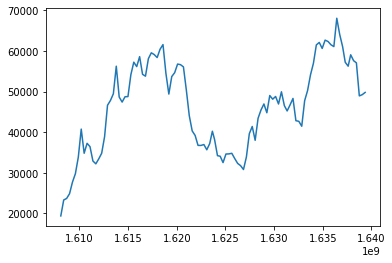

In [11]:
fig = plt.plot('timestamp', 'price', data=df_btc[::1000])

Ahora decidimos que el maximo de tiempo que vamos a predecir, es 7 días. Por lo que debemos eliminar lo tweets más recientes que no tienen valores en "data/btc_values.csv" 7 días después (La idea habría sido definirlos al principio, para no tener que conseguir el sentiment analysis de tweets que vamos a borrar o tener que usar la API de twitter para usuarios que no necesitamos. Pero no tenemos el tiempo para volver a correr el sentiment analysis. Aunque la posicion de este cleanup **no tiene efecto sobre el resultado final**)

In [6]:
day_7 = 7*24*60*60

p_len = len(df)
df = df[df["date"]+day_7 < np.max(df_btc['timestamp'])]
df = df.reset_index(drop=True)
print(f"{p_len-len(df)} tweets eliminados ({len(df)} restantes)")

173 tweets eliminados (4641 restantes)


Ahora, encontremos los extremos temporales de los tweets, para no tener que mostrar todo el historial que tenemos disponible

In [7]:
max = np.max(df['date']) + day_7
min = np.min(df['date'])

def get_price_near(timestamp):
    return df_btc.iloc[(df_btc['timestamp']-timestamp).abs().argsort()].iloc[0]["price"]


In [8]:
p_len = len(df_btc)
df_btc = df_btc[df_btc["timestamp"] > min]
df_btc = df_btc[df_btc["timestamp"] < max]
print(f"{p_len-len(df_btc)} fechas eliminadas ({len(df_btc)} restantes)")

5471 fechas eliminadas (100422 restantes)


Ahora, encontremoas a un tweet al azar y mostremoslo en el grafico (tweet 8)

1638726338.0 49242.23519008295


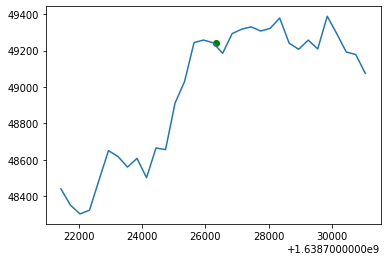

In [111]:
tweet_date = df.iloc[8]['date']

df_btc_short = df_btc[df_btc["timestamp"] > tweet_date-5000]
df_btc_short = df_btc_short[df_btc_short["timestamp"] < tweet_date+5000]

print(tweet_date, get_price_near(tweet_date))

fig = plt.plot('timestamp', 'price', data=df_btc_short)
plt.scatter(tweet_date, get_price_near(tweet_date), color='green')

Nos podemos dar cuenta de que nos estamos acercando a nuestro objetivo, ahora hay que ver "cuanto" cambia el precio del bitcoin después de cada tweet

Para esto, vamos a crear 6 nuevas columnas a los tweets: Los deltas de los precios después de 5 min, 30 min, 1h, 5h, 1d, 7d

In [9]:
min_5 = 5*60
min_30 = 30*60
hour_1 = 60*60
hour_5 = 5*hour_1
day_1= 24*hour_1
# day_7 is already defined

# def date_func(row):
#     now_price = get_price_near(row["date"])
#     if row['eri_hispanic'] == 1 :
#         return 'Hispanic'

time_5m = []
time_30m = []
time_1h = []
time_5h = []
time_1d = []
time_7d = []

tweet_amount = len(df.date)
for d_id, tweet_date in enumerate(df.date):
    print(f"{d_id}/{tweet_amount}\r", end="")
    now_price = get_price_near(tweet_date)
    time_5m.append(get_price_near(tweet_date+min_5)-now_price)
    time_30m.append(get_price_near(tweet_date+min_30)-now_price)
    time_1h.append(get_price_near(tweet_date+hour_1)-now_price)
    time_5h.append(get_price_near(tweet_date+hour_5)-now_price)
    time_1d.append(get_price_near(tweet_date+day_1)-now_price)
    time_7d.append(get_price_near(tweet_date+day_7)-now_price)

df["price_delta_5m"] = time_5m
df["price_delta_30m"] = time_30m
df["price_delta_1h"] = time_1h
df["price_delta_5h"] = time_5h
df["price_delta_1d"] = time_1d
df["price_delta_7d"] = time_7d
print("Done!"+" "*20)

Done!                    


In [10]:
df.head()

Unnamed: 0            p_id          date  \
0        1364     PeterSchiff  1.638752e+09   
1        1370       BobLoukas  1.638748e+09   
2        1377   AirdropStario  1.638746e+09   
3        1382     WatcherGuru  1.638738e+09   
4        1384  airdropinspect  1.638738e+09   

                                               tweet sentiment_begin  \
0  Bitcoin pumpers claim that #Bitcoin is a bette...        Negative   
1  Looking over 10 years of #Bitcoin Price action...        Negative   
2  💧 Metavast Inu Airdrop . . 🏆 Task:          ➕ ...         Neutral   
3  Value of $1,000 invested 1 year ago. . #Shib: ...        Negative   
4  New airdrop: AAG Ventures x reBaked (AAG. Tota...        Negative   

  sentiment_end  sentiment_very_positive  sentiment_positive  \
0      Negative                        0                   0   
1      Negative                        0                   0   
2      Negative                        0                   0   
3       Neutral                        0                   0   
4      Negative                        0                   0   

   sentiment_neutral  sentiment_negative  sentiment_very_negative  \
0                  1                   3                        0   
1                  2                   2                        0   
2                  3                   4                        0   
3                 15                   1                        0   
4                  4                   5                        0   

   price_delta_5m  price_delta_30m  price_delta_1h  price_delta_5h  \
0      -43.184485       307.327284     -182.368481      278.662125   
1       19.342934      -345.940584     -497.161246        4.808592   
2     -101.717489      -248.309395     -594.249979     -246.261499   
3       75.159941         2.762044      332.786499      -47.289112   
4      -85.581230      -385.060737      180.129040     -240.666796   

   price_delta_1d  price_delta_7d  
0     2019.589921     1185.703940  
1     1189.025789      868.866305  
2     1127.150375      850.681415  
3      -98.038891     1313.017148  
4      -83.924315     1270.157164

Eliminar columnas sin nombre

In [11]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

Ahora podemos empezar con la regreción

In [136]:
df_analysis = df.copy(deep=True)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

p_len = len(df)
for u_id, user in enumerate(df.iloc):
    print(f"{u_id+1}/{p_len}\r", end="")
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns", )
print("Done!" + " "*20)

Done!                    


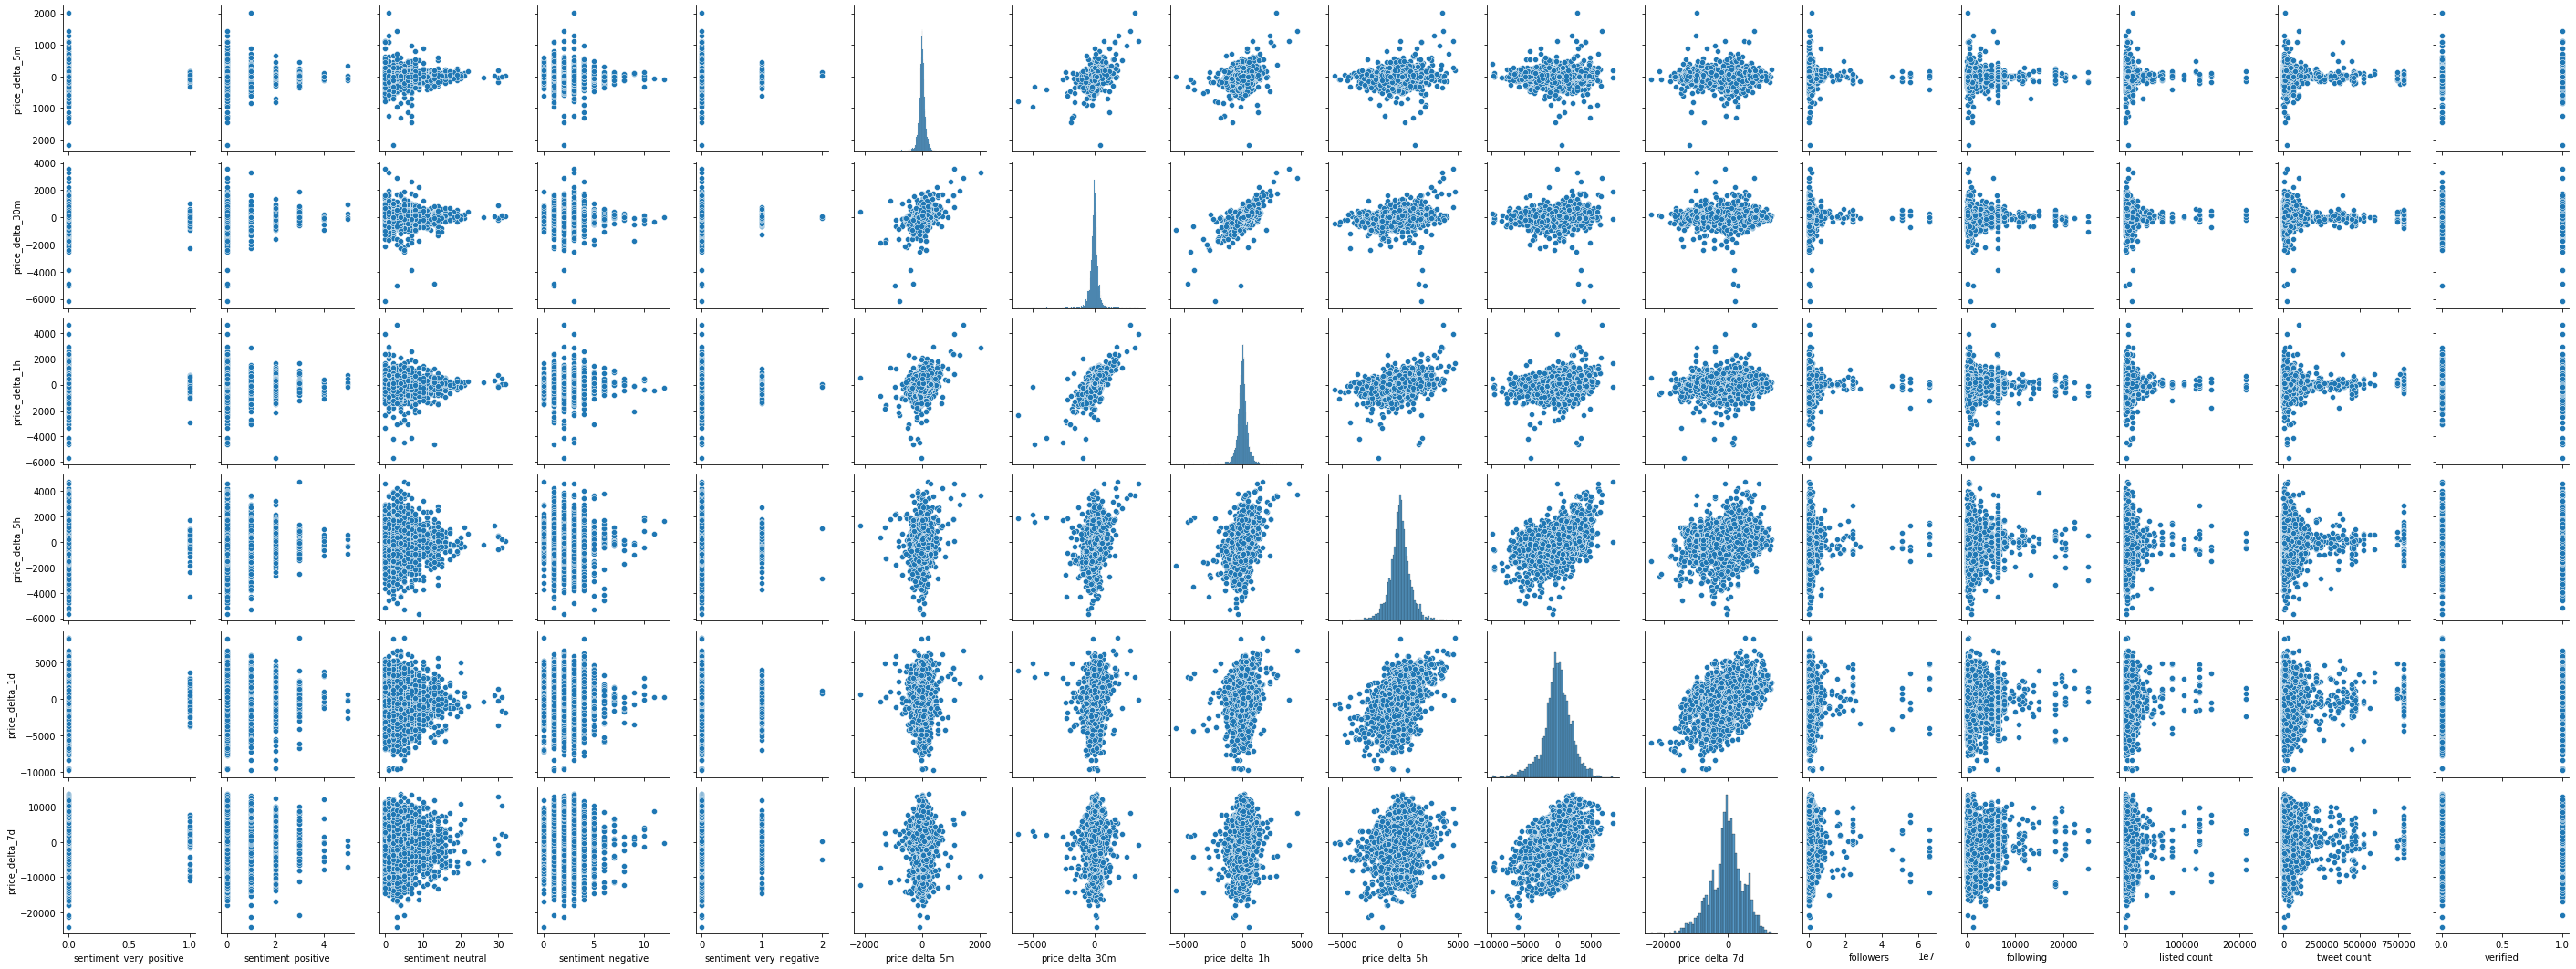

In [132]:
sns.pairplot(df_analysis,y_vars=['price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d'])

Como podemos ver con los graficos en x=sentiment_*, mientras más frases en el tweet, tiende a haber un menor cambio de precio, pero como podemos ver, también hay una menor cantidad de tweets mientras mayor cantidad de frases con algun sentimiento, por lo que no es una metrica que podamos utilizar directamente sin juntarla con alguna otra.

Utilizando las metricas de delta de precios, para predecir los futuros precios, solo se ve factible a corto plazo, ya que por ejemplo con el grafico de price_delta_5m vs el price_delta_7d podemos ver que la varianza de uno, no afecta **mucho** al otro.

La cantidad de followers, parece generar menos cambios en el precio mientras mayor sea el numero de seguidores, pero esto, puede ser porque estas personas tienden a ser más objetivos tratando de no interferir. Esto lo podríamos ver generando graficos con los followers y los sentimientos de los mensajes vs el delta de precios.

El following, no parece tener mucho efecto al largo plazo, lo que estaba dentro de lo esperado, aunque por otra parte, a corto plazo, se tiene un comportamiento similar al de los followers, pero esto debe pasar porque no hay suficientes mensajes.

El listed_count tiene comportamiento como el de following, lo que no era de esperarse, ya que uno pensaría que mientras más cantidad de grupos una persona pertenece, más influencial sería. Pero denuevo, no es una metrica que podamos juzgar directamente sin otras.

El tweet_count, muestra un comportamiento interesante, ya que como podemos ver, a medida que se incrementa la cantidad de tweets/persona, menor cantidad de tweets relacionados a esta investigación encontramos, pero sobre 750.000 tweets/persona encontramos un grupo que aparte de ser influyentes incluso a largo plazo (pero se necesita más información para ser concluyentes de esto), tenemos que repentinamente, tenemos una mayor cantidad de tweets recolectados. Estos, por ejemplo, pueden ser bots que anuncian noticias relacionadas al bitcoin.

Para los usuarios verificados, vemos que en 30m y 1h, hay tweets que **parecen** afectar al delta del precio en esos instantes más que los no verificados.

<AxesSubplot:xlabel='sentiment_negative', ylabel='price_delta_1d'>

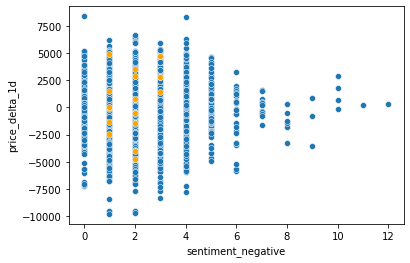

In [191]:
df_analysis_sub = df_analysis.copy(deep=True)

sns.scatterplot('sentiment_negative', 'price_delta_1d', data=df_analysis_sub)
sns.scatterplot('sentiment_negative', 'price_delta_1d', data=df_analysis_sub[df_analysis_sub["followers"] > 5e7], color="orange")

2

1. Regression para desde followers, ... llegar a el delta de precios
2. K-Means clustering para desde followers, ...usuario... saber si puede enviar un tweet que pueda afectar en más de {x} USD el precio.

In [313]:
def do_regression(x, y, printout=True):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 64)
    scaler = sklearn.preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    #degree=3
    #poly_reg=make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree),LinearRegression())
    #poly_reg.fit(x_train,y_train)

    lin_reg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,10,10,20), random_state=1)

    #lin_reg=LinearRegression()
    lin_reg.fit(x_train, y_train)

    y_prediction =  lin_reg.predict(x_test)
    score=r2_score(y_test,y_prediction)
    if printout:
        print(f"r2 score is {score:.4f}")
        print(f"mean_squared_error is {mean_squared_error(y_test,y_prediction):.4f}")
        print(f"root_mean_squared_error is {np.sqrt(mean_squared_error(y_test,y_prediction)):.4f}")
        res_df = pd.DataFrame()
        res_df["Predicted"] = y_prediction
        res_df["Actual"] = y_test.reset_index(drop=True)
        print(f"{res_df}%")
    return lin_reg, score

In [311]:
df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

reg_5m, _ = do_regression(df_base_reg, df["price_delta_5m"])
reg_30m, _ = do_regression(df_base_reg, df["price_delta_30m"])
reg_1h, _ = do_regression(df_base_reg, df["price_delta_1h"])
reg_5h, _ = do_regression(df_base_reg, df["price_delta_5h"])
reg_1d, _ = do_regression(df_base_reg, df["price_delta_1d"])
reg_7d, _ = do_regression(df_base_reg, df["price_delta_7d"])

r2 score is -0.0067
mean_squared_error is 23762.5757
root_mean_squared_error is 154.1511
      Predicted      Actual
0     -3.775934   30.149892
1     10.186025  714.299143
2     -9.316415  -61.721387
3     -2.155366    3.494936
4     -0.481531   31.642708
...         ...         ...
1156  -3.397374   12.060399
1157  -4.964664  147.761158
1158   2.745398   61.143452
1159  -8.346202  -10.017012
1160   2.442685   65.101870

[1161 rows x 2 columns]%
r2 score is -0.0053
mean_squared_error is 151137.6060
root_mean_squared_error is 388.7642
      Predicted      Actual
0     -8.613555  852.750814
1    -12.329228   96.178466
2    -22.749921  -80.319279
3     -9.876629   41.812241
4     -5.961303  -57.410235
...         ...         ...
1156  -2.018063    8.792740
1157 -24.589033  151.474167
1158  12.914655   63.574893
1159 -35.743786 -262.441430
1160  48.349507  -42.760375

[1161 rows x 2 columns]%
r2 score is -0.0090
mean_squared_error is 253802.0122
root_mean_squared_error is 503.7877
      P

Como podemos ver, la regresión, no está nada de cerca, (Ridge y lasso no fueron muy diferentes. Cambiar variables x, tampoco ayudó)

A lo mejor podemos
Por tanto, vamos a tener que cambiar nuestra mirada e intentar K-Means clustering, para ver si el precio sube o baja

p_id          date  \
0         PeterSchiff  1.638752e+09   
1           BobLoukas  1.638748e+09   
2       AirdropStario  1.638746e+09   
3         WatcherGuru  1.638738e+09   
4      airdropinspect  1.638738e+09   
...               ...           ...   
4636  theRealKiyosaki  1.609522e+09   
4637         woonomic  1.609507e+09   
4638         woonomic  1.609506e+09   
4639      jackmallers  1.609470e+09   
4640     JonErlichman  1.609461e+09   

                                                  tweet sentiment_begin  \
0     Bitcoin pumpers claim that #Bitcoin is a bette...        Negative   
1     Looking over 10 years of #Bitcoin Price action...        Negative   
2     💧 Metavast Inu Airdrop . . 🏆 Task:          ➕ ...         Neutral   
3     Value of $1,000 invested 1 year ago. . #Shib: ...        Negative   
4     New airdrop: AAG Ventures x reBaked (AAG. Tota...        Negative   
...                                                 ...             ...   
4636  Happy New Year. 2021 great year for gold silve...        Positive   
4637  #Bitcoin is the first invention of an Internet...        Negative   
4638  If you're looking for an entry to HODL Bitcoin...        Negative   
4639  What’s now known: You can’t save in USD. . Wha...        Negative   
4640  Things that didn’t exist on New Year’s Eve 30 ...        Negative   

     sentiment_end  sentiment_very_positive  sentiment_positive  \
0         Negative                        0                   0   
1         Negative                        0                   0   
2         Negative                        0                   0   
3          Neutral                        0                   0   
4         Negative                        0                   0   
...            ...                      ...                 ...   
4636      Positive                        0                   4   
4637      Negative                        0                   0   
4638      Negative                        0                   0   
4639       Neutral                        0                   3   
4640       Neutral                        0                   0   

      sentiment_neutral  sentiment_negative  sentiment_very_negative  \
0                     1                   3                        0   
1                     2                   2                        0   
2                     3                   4                        0   
3                    15                   1                        0   
4                     4                   5                        0   
...                 ...                 ...                      ...   
4636                  2                   1                        0   
4637                  4                   2                        0   
4638                  2                   3                        0   
4639                  4                   2                        0   
4640                 31                   1                        0   

      price_delta_5m  price_delta_30m  price_delta_1h  price_delta_5h  \
0         -43.184485       307.327284     -182.368481      278.662125   
1          19.342934      -345.940584     -497.161246        4.808592   
2        -101.717489      -248.309395     -594.249979     -246.261499   
3          75.159941         2.762044      332.786499      -47.289112   
4         -85.581230      -385.060737      180.129040     -240.666796   
...              ...              ...             ...             ...   
4636      -13.696423       -57.253248     -177.744965       64.265784   
4637       16.032057        52.997608      149.369605      -91.967829   
4638     -117.282678        -7.245087      100.253010     -234.084034   
4639       23.428448        20.611157       82.665972      -96.383523   
4640        7.390930       169.752118      476.312967      225.862443   

      price_delta_1d  price_delta_7d  
0        2019.589921     1185.703940  
1        1189.025789  

In [76]:
df_cluster_values = df[["price_delta_5m","price_delta_30m","price_delta_1h","price_delta_5h","price_delta_1d","price_delta_7d"]]
for col in df_cluster_values.columns:
    df_cluster_values.loc[df_cluster_values[col] >= 0, col] = 1
    df_cluster_values.loc[df_cluster_values[col] < 0, col] = 0
    df_cluster_values[col] = df_cluster_values[col].astype("int64").astype("category")

price_delta_5m price_delta_30m price_delta_1h price_delta_5h  \
0                 0               1              0              1   
1                 1               0              0              1   
2                 0               0              0              0   
3                 1               1              1              0   
4                 0               0              1              0   
...             ...             ...            ...            ...   
4636              0               0              0              1   
4637              1               1              1              0   
4638              0               0              1              0   
4639              1               1              1              0   
4640              1               1              1              1   

     price_delta_1d price_delta_7d  
0                 1              1  
1                 1              1  
2                 1              1  
3                 0              1  
4                 0              1  
...             ...            ...  
4636              1              1  
4637              1              1  
4638              1              1  
4639              1              1  
4640              1              1  

[4641 rows x 6 columns]

In [353]:
def do_clustering(x, y, printout=True):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 64)

    scaler = sklearn.preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    cluster_clas = KNeighborsClassifier(3)
    cluster_clas.fit(x_train, y_train)

    y_prediction =  cluster_clas.predict(x_test)
    score = r2_score(y_test,y_prediction)

    if printout:
        print(f"r2 score is {score:.4f}")
        print(f"mean_squared_error is {mean_squared_error(y_test,y_prediction):.4f}")
        print(f"root_mean_squared_error is {np.sqrt(mean_squared_error(y_test,y_prediction)):.4f}")
        print(f"{(len(y_prediction[y_prediction == y_test])/len(y_prediction)*100):.3}% are correct cases")
    return cluster_clas, score

In [169]:
df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

reg_5m, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_5m"])
reg_30m, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_30m"])
reg_1h, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_1h"])
reg_5h, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_5h"])
reg_1d, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_1d"])
reg_7d, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_7d"])


r2 score is -0.8571
mean_squared_error is 0.4643
root_mean_squared_error is 0.6814
53.6% are correct cases
r2 score is -1.0618
mean_squared_error is 0.5151
root_mean_squared_error is 0.7177
48.5% are correct cases
r2 score is -1.0656
mean_squared_error is 0.5151
root_mean_squared_error is 0.7177
48.5% are correct cases
r2 score is -0.9580
mean_squared_error is 0.4892
root_mean_squared_error is 0.6995
51.1% are correct cases
r2 score is -1.0332
mean_squared_error is 0.5082
root_mean_squared_error is 0.7129
49.2% are correct cases
r2 score is -1.0422
mean_squared_error is 0.5090
root_mean_squared_error is 0.7135
49.1% are correct cases


Ninguno de los 3 modelos que podríamos usar para este proyecto (regresión, clasificación supervisada, clustering) logró hacer una predicción mejor que lanzar una moneda al aire

Si tuvieramos más tiempo, nos habría gustado filtrar menos tweets, pero por problemas de tiempo tuvimos que eliminar muchos para que el sentiment analysis no se demorara tanto. De todas formas, es muy probable que nos habría pasado lo mismo. También nos habria gustado hacer una red neuronal, para predecir este comportamiento más complejo

In [237]:
'sentiment_very_positive', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_very_negative', 'price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d', 'followers', 'following', 'listed count', 'tweet count', 'verified'

'sentiment_very_positive', 'sentiment_positive', 'sentiment_neutral', 'sentiment_negative', 'sentiment_very_negative', 'price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d', 'followers', 'following', 'listed count', 'tweet count', 'verified', 

In [130]:
df_dbtc = df[df["p_id"] == "DocumentingBTC"]

df_analysis = df_dbtc.copy(deep=True)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

p_len = len(df_dbtc)
for u_id, user in enumerate(df_dbtc.iloc):
    print(f"{u_id+1}/{p_len}\r", end="")
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns", )

df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

df_ccols = ["price_delta_5m","price_delta_30m","price_delta_1h","price_delta_5h","price_delta_1d","price_delta_7d"]
for col in df_ccols:
    df_dbtc.loc[df_dbtc[col] >= 0, col] = 1
    df_dbtc.loc[df_dbtc[col] < 0, col] = 0
    df_dbtc[col] = df_dbtc[col].astype("int64").astype("category")

reg_5m, _ = do_clustering(df_base_reg, df_dbtc["price_delta_5m"])
reg_30m, _ = do_clustering(df_base_reg, df_dbtc["price_delta_30m"])
reg_1h, _ = do_clustering(df_base_reg, df_dbtc["price_delta_1h"])
reg_5h, _ = do_clustering(df_base_reg, df_dbtc["price_delta_5h"])
reg_1d, _ = do_clustering(df_base_reg, df_dbtc["price_delta_1d"])
reg_7d, _ = do_clustering(df_base_reg, df_dbtc["price_delta_7d"])

r2 score is -0.7810
mean_squared_error is 0.4432
root_mean_squared_error is 0.6657
55.7% are correct cases
r2 score is -1.1364
mean_squared_error is 0.5341
root_mean_squared_error is 0.7308
46.6% are correct cases
r2 score is -1.1768
mean_squared_error is 0.5341
root_mean_squared_error is 0.7308
46.6% are correct cases
r2 score is -1.0842
mean_squared_error is 0.5114
root_mean_squared_error is 0.7151
48.9% are correct cases
r2 score is -0.8420
mean_squared_error is 0.4545
root_mean_squared_error is 0.6742
54.5% are correct cases
r2 score is -0.5463
mean_squared_error is 0.3864
root_mean_squared_error is 0.6216
61.4% are correct cases


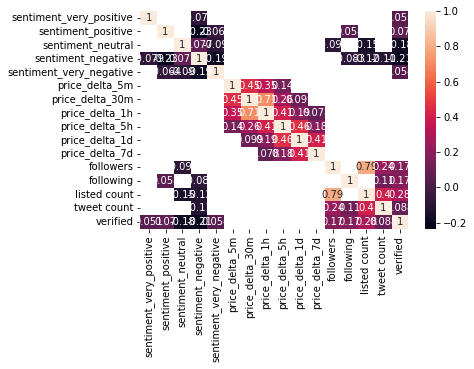

In [188]:
correlations = df_analysis.corr()
sns.heatmap(correlations[np.abs(correlations) > .05],annot=True);

In [170]:
df_analysis["followers"].describe()

count    4.641000e+03
mean     1.318697e+06
std      4.069869e+06
min      1.504290e+05
25%      3.213670e+05
50%      6.631780e+05
75%      1.369842e+06
max      6.619848e+07
Name: followers, dtype: float64

Podemos buscar si hay una corelación entre cantidad de tweets y precio

Reload all tweets and clean them

In [244]:
df_tweets = pd.DataFrame()
df_tweets["date"] = df["date"]
df_tweets["followers"] = df_analysis["followers"]


Vamos a separar los tweets por cantidad de seguidores
< 3.213670e+05
< 6.631780e+05
< 1.369842e+06
. el resto

In [340]:
tweet_first_tm = datetime.fromtimestamp(np.min(df["date"]))
tweet_last_tm = datetime.fromtimestamp(np.max(df["date"]))

current_day = datetime(tweet_first_tm.year, tweet_first_tm.month, tweet_first_tm.day)
end_day = datetime(tweet_last_tm.year, tweet_last_tm.month, tweet_last_tm.day)

date_tab = []
price_tab = []

while current_day < end_day:
    next_day = current_day + timedelta(days=1)
    date_tweets = df_tweets[df_tweets["date"] >= current_day.timestamp()]
    date_tweets = date_tweets[date_tweets["date"] < next_day.timestamp()]

    price_day = df_btc[df_btc["timestamp"] > current_day.timestamp()]
    price_day = price_day[price_day["timestamp"] < next_day.timestamp()]["price"]

    date_tab.append([current_day.timestamp(), next_day.timestamp(),
                     len(date_tweets[date_tweets["followers"] < 3.213670e+05]),
                     len(date_tweets[(date_tweets["followers"] < 6.631780e+05) & (date_tweets["followers"] >= 3.213670e+05)]),
                     len(date_tweets[(date_tweets["followers"] < 1.369842e+06) & (date_tweets["followers"] >= 6.631780e+05)]),
                     len(date_tweets[date_tweets["followers"] > 1.369842e+06]),
                     len(date_tweets)])
    price_tab.append([price_day.iloc[0],
                      price_day.iloc[-1],
                      price_day.iloc[-1] - price_day.iloc[0],
                      np.abs(price_day.iloc[-1] - price_day.iloc[0]),
                      1 if price_day.iloc[-1] > price_day.iloc[0] else 0])

    current_day = next_day
df_follows = pd.DataFrame(date_tab, columns=["start_date", "end_date", "follow_1", "follow_2", "follow_3", "follow_4", "follow_5"])
df_t_prices = pd.DataFrame(price_tab, columns=["price_start", "price_end", "price_delta", "price_delta_abs", "increment"])

In [341]:
df_t_prices["increment"] = df_t_prices["increment"].astype("category")

<AxesSubplot:>

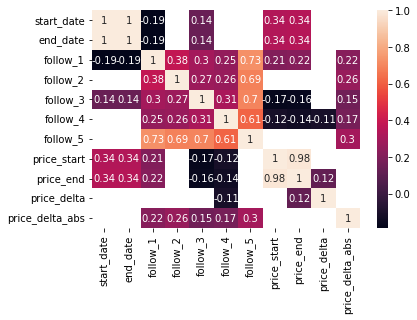

In [361]:
mx = pd.concat([df_follows, df_t_prices], axis=1)
hm = mx.corr()
sns.heatmap(hm[np.abs(hm)>0.1], annot=True)

<AxesSubplot:xlabel='follow_5', ylabel='price_delta_abs'>

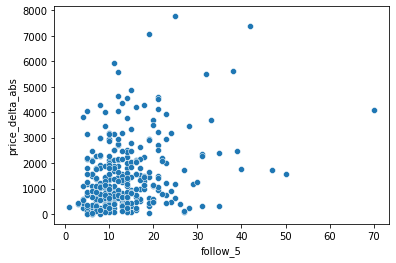

In [370]:
sns.scatterplot('follow_5', 'price_delta_abs', data=mx)

Como podemos ver, tienen alguna correlación la cantidad de tweets y el cambio en el precio, mientras más tweets existan, más tiende a cambiar el precio.

In [337]:
price_delta = do_regression(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["price_delta"])

r2 score is -0.0209
mean_squared_error is 3438551.4727
root_mean_squared_error is 1854.3332
     Predicted       Actual
0   178.094211   840.101588
1   328.130671 -1053.726463
2   -73.895969  -324.617976
3   153.379844 -2104.914811
4  -160.081262 -1882.043709
..         ...          ...
80  170.828644 -1138.264151
81   72.642833  -771.497128
82  151.091373   929.374130
83 -106.103371   559.375232
84  123.204561  -843.294194

[85 rows x 2 columns]%


In [338]:
price_delta_abs = do_regression(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["price_delta_abs"])

r2 score is -0.0569
mean_squared_error is 1473123.2944
root_mean_squared_error is 1213.7229
      Predicted       Actual
0    694.175908   840.101588
1   1098.044422  1053.726463
2   1086.323359   324.617976
3    813.666547  2104.914811
4   1354.018756  1882.043709
..          ...          ...
80  1405.966656  1138.264151
81  1595.684263   771.497128
82   828.257365   929.374130
83  1588.584841   559.375232
84   841.501116   843.294194

[85 rows x 2 columns]%


In [425]:
incr = do_clustering(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["increment"])

r2 score is -0.8847
mean_squared_error is 0.4706
root_mean_squared_error is 0.6860
52.9% are correct cases


In [360]:
do_regression(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["increment"])

r2 score is -0.2552
mean_squared_error is 0.3134
root_mean_squared_error is 0.5598
    Predicted Actual
0    0.344384      1
1    0.899884      0
2    0.326068      0
3    0.608295      0
4    0.562122      0
..        ...    ...
80   0.255439      0
81   0.126898      0
82   0.347635      1
83   0.282213      1
84   0.541325      0

[85 rows x 2 columns]%


(MLPRegressor(hidden_layer_sizes=(20, 10, 10, 20), random_state=1),
 -0.25516438016537846)

In [377]:
df2 = pd.read_csv("data/tweets.csv")

In [382]:
tweet_first_tm = datetime.fromtimestamp(np.min(df2["date"]))
tweet_last_tm = datetime.fromtimestamp(np.max(df2["date"]))

current_day = datetime(tweet_first_tm.year, tweet_first_tm.month, tweet_first_tm.day)
end_day = datetime(tweet_last_tm.year, tweet_last_tm.month, tweet_last_tm.day)

date_tab = []
price_tab = []

while current_day < end_day:
    next_day = current_day + timedelta(days=1)
    date_tweets = df2[df2["date"] >= current_day.timestamp()]
    date_tweets = date_tweets[date_tweets["date"] < next_day.timestamp()]

    price_day = df_btc[df_btc["timestamp"] > current_day.timestamp()]
    price_day = price_day[price_day["timestamp"] < next_day.timestamp()]["price"]

    date_tab.append([current_day.timestamp(), next_day.timestamp(), len(date_tweets)])
    price_tab.append([price_day.iloc[0],
                      price_day.iloc[-1],
                      price_day.iloc[-1] - price_day.iloc[0],
                      np.abs(price_day.iloc[-1] - price_day.iloc[0]),
                      1 if price_day.iloc[-1] > price_day.iloc[0] else 0])

    current_day = next_day
df2_follows = pd.DataFrame(date_tab, columns=["start_date", "end_date", "tweets"])
df2_t_prices = pd.DataFrame(price_tab, columns=["price_start", "price_end", "price_delta", "price_delta_abs", "increment"])

<AxesSubplot:>

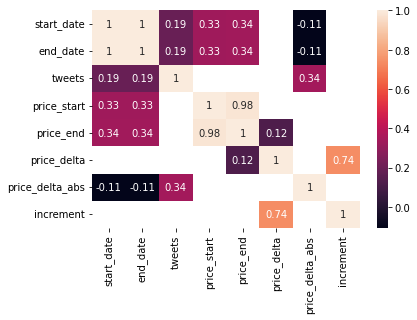

In [383]:
mx = pd.concat([df2_follows, df2_t_prices], axis=1)
hm = mx.corr()
sns.heatmap(hm[np.abs(hm)>0.1], annot=True)

In [413]:
#price_delta = do_regression(df2_follows.drop(["start_date", "end_date"], axis="columns"), df2_t_prices["price_delta"])
price_delta = do_regression(df2_follows.drop(["start_date", "end_date"], axis="columns"), df2_t_prices["price_delta_abs"])

r2 score is 0.0558
mean_squared_error is 1457696.2375
root_mean_squared_error is 1207.3509
      Predicted       Actual
0   1314.881046   939.420833
1   1324.771868   558.048371
2   1320.815539  1339.871151
3   1322.793704  1220.879334
4   1325.760950  2529.732800
..          ...          ...
82  1452.808217   731.498313
83  1751.281703  3183.737614
84  1319.826457   151.258686
85  1316.364670   234.368319
86  1319.331916  1558.039107

[87 rows x 2 columns]%


Ahora, como tenemos el modelo de regresión, podemos hacer unas prediciones

In [423]:
price_delta[0].predict(pd.DataFrame([10, 50, 100, 500, 1000]))

array([  6449.44707339,  29204.48262869,  57648.27707281, 285198.63262582,
       569636.57706707])

Como podemos ver, el modelo está contemplando a futuro. Pero como los datos no están muy alineados, el error es muy alto. Como podemos ver en el siguiente scatterplot, el modelo tampoco es adecuado para clasificar los cambios basados en si el precio aumentó o disminuyó.

<AxesSubplot:xlabel='tweets', ylabel='price_delta_abs'>

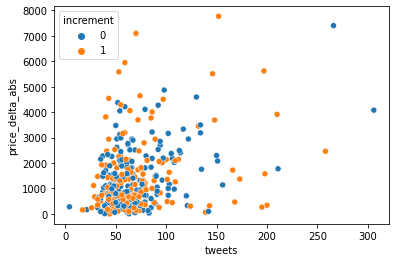

In [424]:
sns.scatterplot('tweets', 'price_delta_abs', data=mx, hue="increment")

In [411]:
incr = do_clustering(df2_follows.drop(["start_date", "end_date"], axis="columns"), df2_t_prices["increment"])

r2 score is -1.2556
mean_squared_error is 0.5632
root_mean_squared_error is 0.7505
43.7% are correct cases
